In [1]:
import logging
import shlex
import sys
from pathlib import Path
from typing import Dict, Tuple, Union

import elettra_toolbox
from elettra_toolbox import ScanConfig
from cpymad.madx import Madx

LOGGER = logging.getLogger(name=__name__)
LOGGER.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
LOGGER.addHandler(handler)

import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from matplotlib import cm, gridspec, patches
from pyhdtoolkit import cpymadtools

plt.rcParams.update({"text.usetex": False})

In [2]:
if os.path.exists("stdout.out"):
    os.remove("stdout.out")

# Launch MAD-X Session
with open("stdout.out", "w") as f:
    madx = Madx(stdout=f)

# Read parameters

from config import parameters, settings

for i in parameters.keys():
    madx.globals[i] = parameters[i]

# Call sequence and optics

madx.call("elettra2_v15_VADER_2.3T.madx")
madx.call("optics_elettra2_v15_VADER_2.3T.madx")

# Initial twiss

madx.use(sequence="ring")
madx.twiss(sequence="ring", table="init_twiss")

# Compute Emittance

madx.input(
    f"""
emit, deltap={madx.globals.deltap};
emit, deltap={madx.globals.deltap};
"""
)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

twiss = madx.table.init_twiss.dframe()


# Let's install some markers

madx.input(
    """
left_marker: marker;
right_marker: marker;
middle_marker: marker;

use, sequence=ring;
seqedit, sequence=ring;
flatten;
install, element=left_marker, at=10.8;
install, element=middle_marker, at=21.6;
install, element=right_marker, at=32.4;
flatten;
endedit;
"""
)

madx.use(sequence="ring")
madx.twiss(sequence="ring")
twiss = madx.table.twiss.dframe()

Emittance x : 1031.9436 pm


In [3]:
elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


(4.4663570802525135e-09, 0.0006081562312737487)

2021-10-20 16:03:37.051 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-20 16:03:37.052 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-20 16:03:37.802 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-20 16:03:37.914 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-20 16:03:40.086 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-20 16:03:40.117 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-20 16:03:40.155 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate
2021-10-20 16:03:40.157 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:695 - Savin

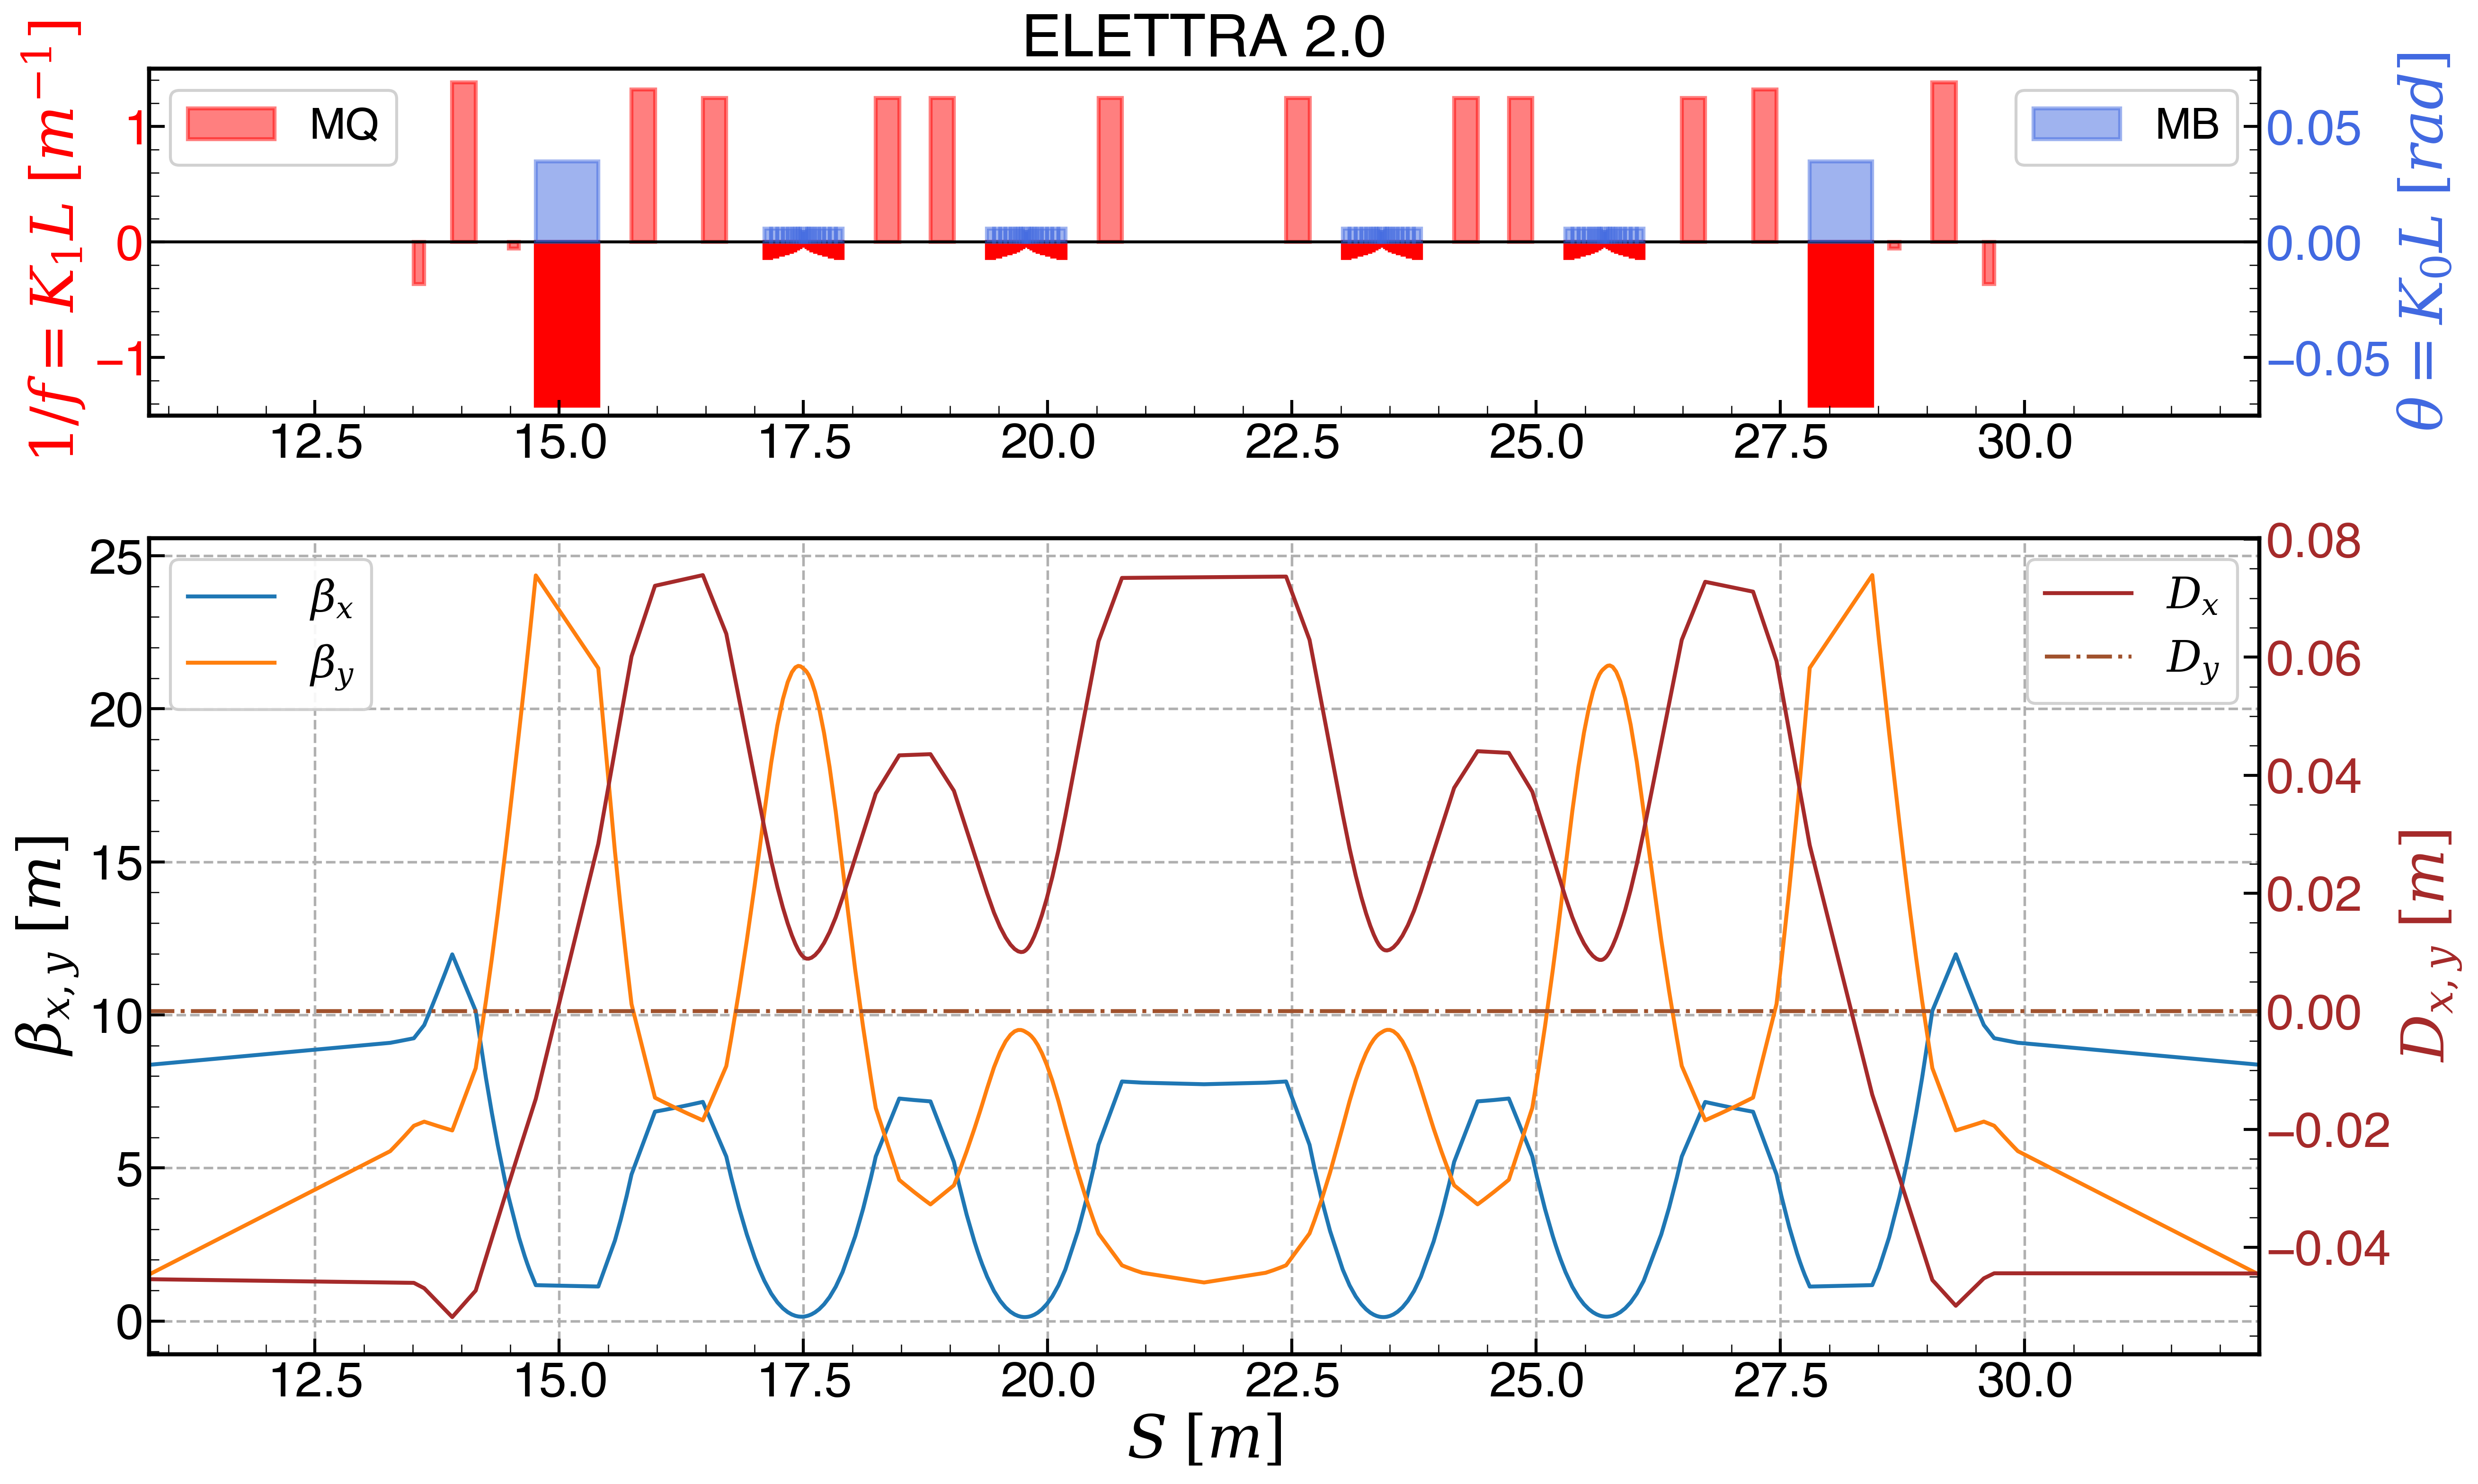

In [4]:
s_start = twiss[twiss.name == "left_marker:1"]["s"][0]
s_end = twiss[twiss.name == "right_marker:1"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
    savefig="raw_no_AB.pdf",
)

In [5]:
# Dispersion matching using the AB

madx.input(
    """
match, sequence=ring;
vary, name=k1_bqf1, step=1e-6;
vary, name=k1_bqf2, step=1e-6;
constraint, range=ll[1], dx=0, dy=0;
constraint, range=ll[3], dx=0, dy=0;
lmdif, calls=1000, tolerance=1e-21;
endmatch;


"""
)

print(madx.globals.tar)

4.501790152049615e-23


2021-10-20 16:04:15.526 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-20 16:04:15.528 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-20 16:04:16.303 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-20 16:04:16.412 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-20 16:04:18.534 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-20 16:04:18.559 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-20 16:04:18.588 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


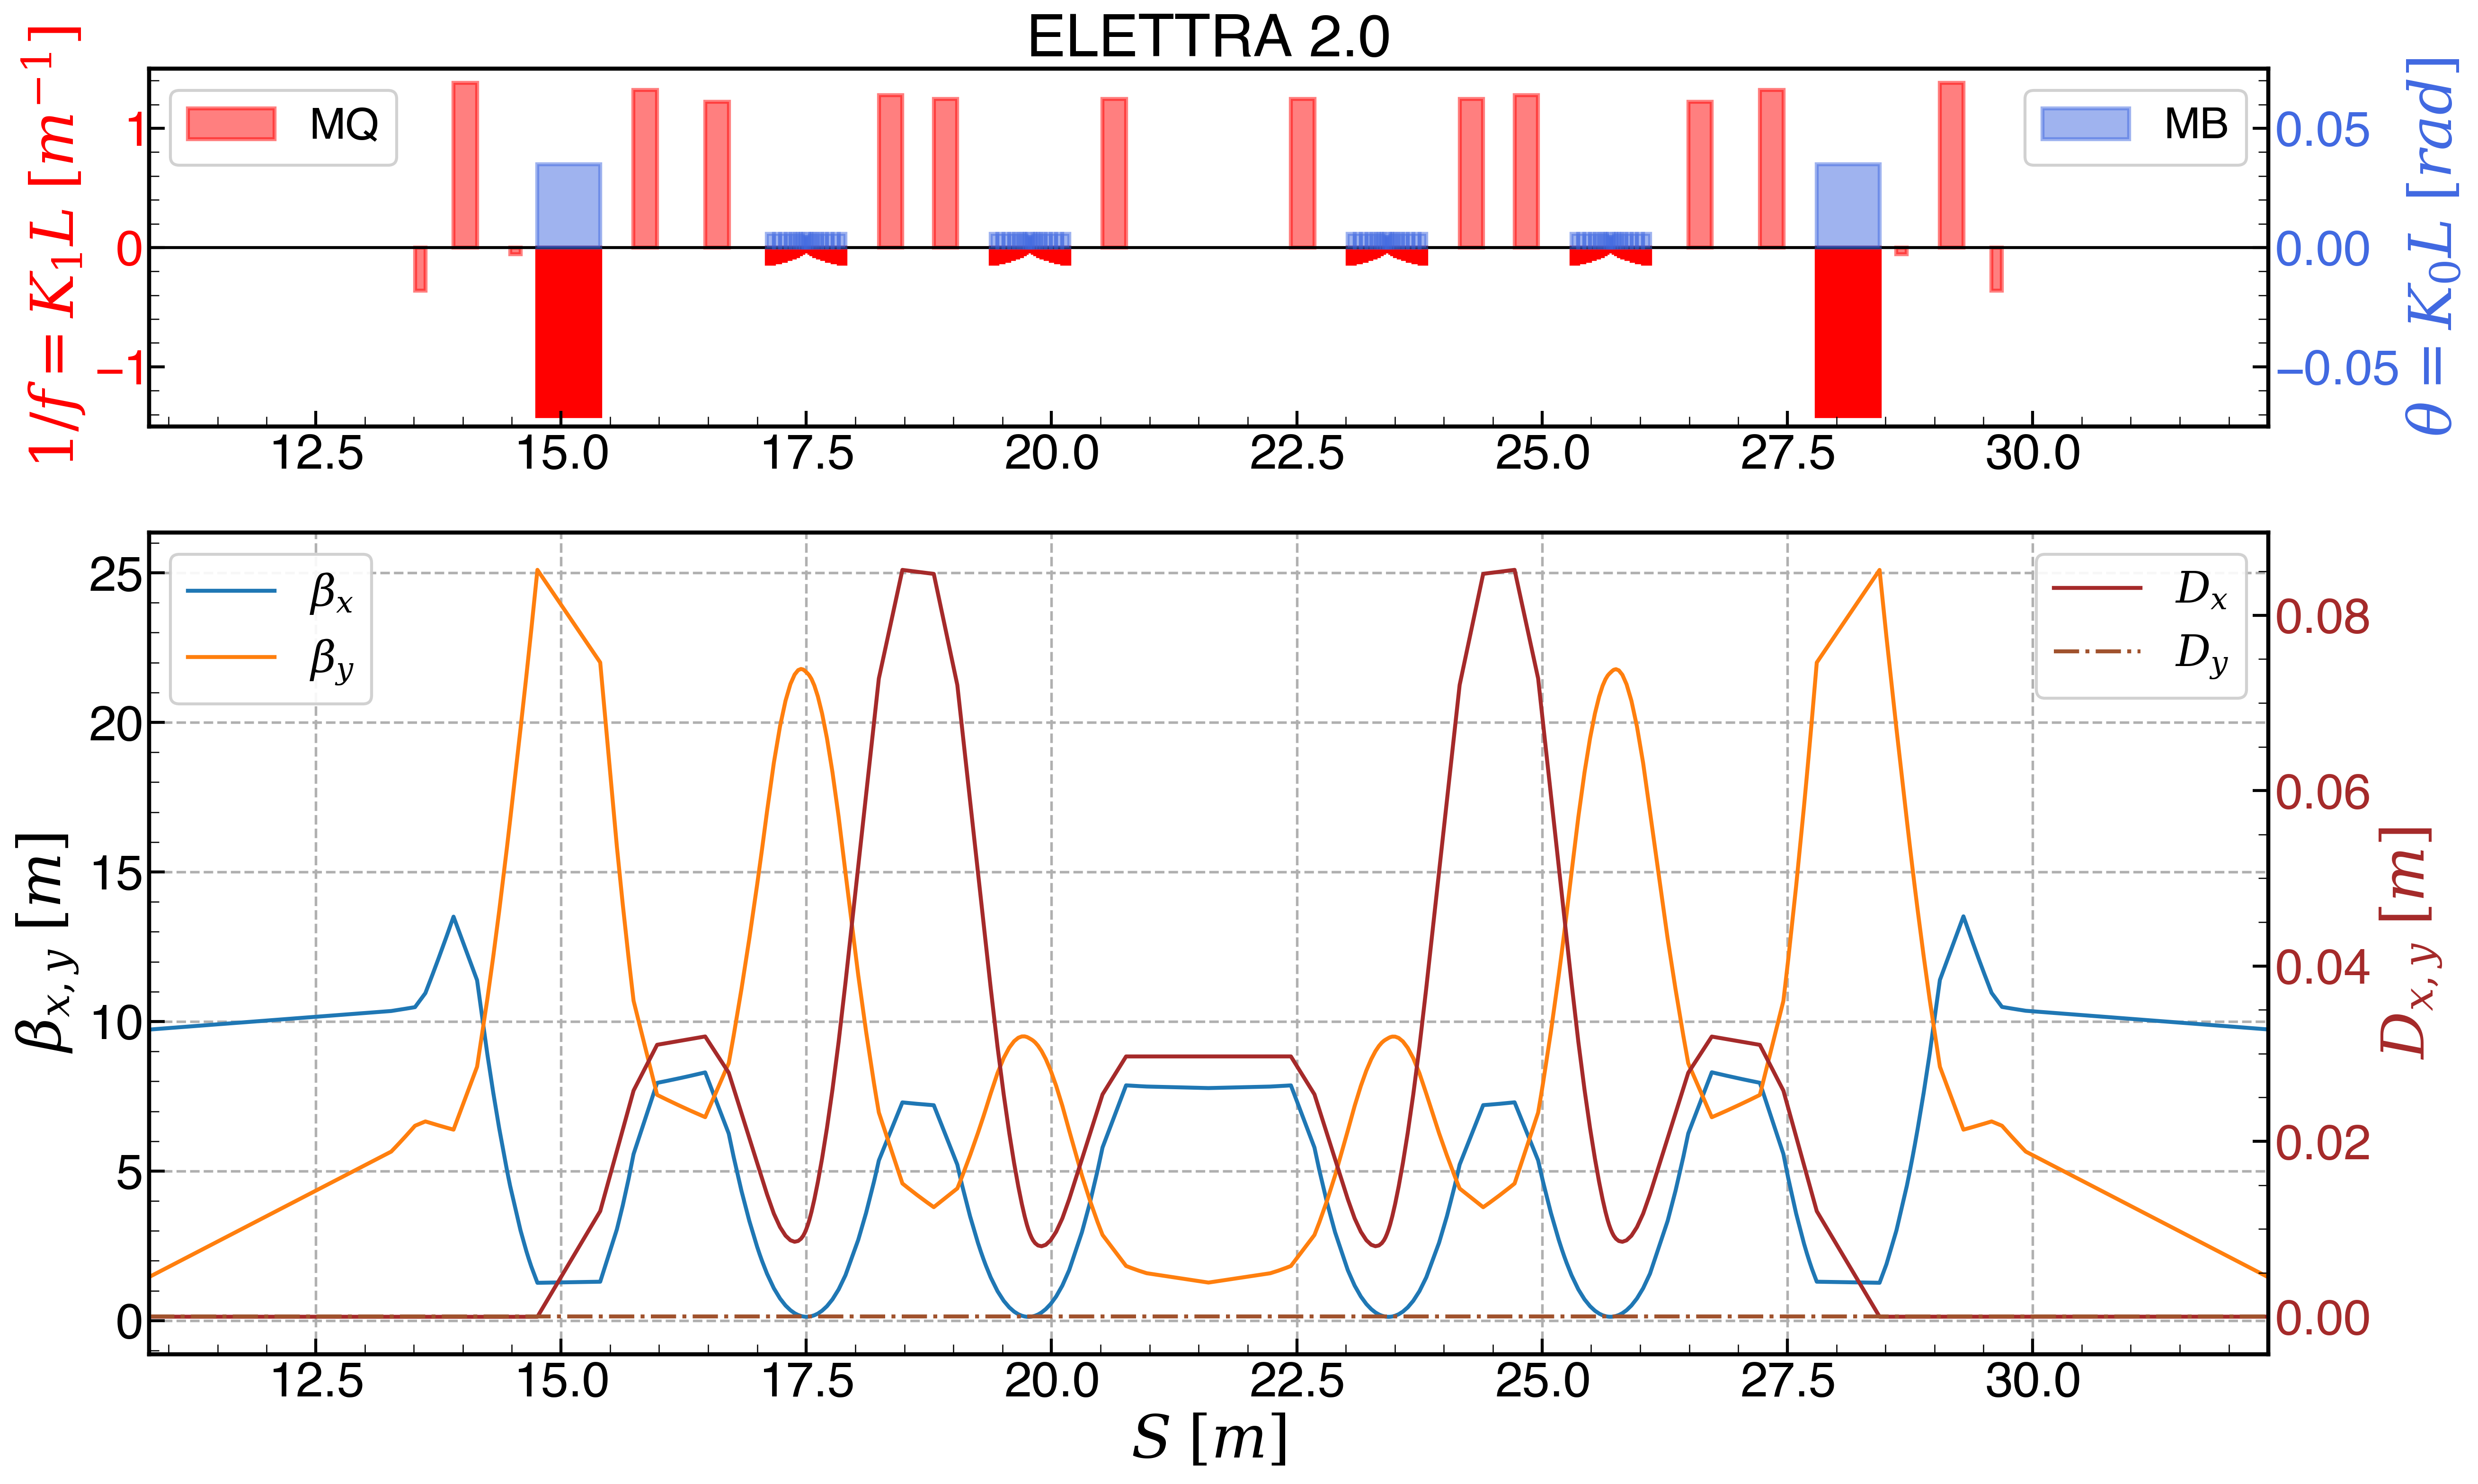

In [6]:
s_start = twiss[twiss.name == "left_marker:1"]["s"][0]
s_end = twiss[twiss.name == "right_marker:1"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [9]:
# Compute Emittance

madx.command.emit(deltap=madx.globals.deltap)
madx.command.emit(deltap=madx.globals.deltap)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

Emittance x : 1211.7887 pm


At this point, scanning the k1 of BF1 is pointless (tried and no results). Let's check the 2 other AB...

In [10]:
madx.globals.k1_bqf3

5.191616161616161

In [15]:
# Scan BQF3

init_k1_bqf3 = 5.191616161616161
delta_k1_bqf3 = 1
n_points = 100

k1_bqf3_scan = ScanConfig("k1_bqf3", initial_value=init_k1_bqf3, scan_start=init_k1_bqf3-delta_k1_bqf3, 
                         scan_end=init_k1_bqf3+delta_k1_bqf3, n_points=n_points)

In [16]:
%%time
emit_res = elettra_toolbox.scan_param_for_emittance(madx, k1_bqf3_scan, 'stdout.out')

Scanning parameter k1_bqf3 for emittance results.
Attempting emittance calculation for value of 4.19162
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.21182
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.23202
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.25222
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.27242
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.29263
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.31283
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.33303
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.35323
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.37343
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.39364
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.41384
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.43404
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.45424
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.47444
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.49465
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.51485
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.53505
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.55525
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.57545
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.59566
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.61586
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.63606
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.65626
Running survey o

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 5.42394
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.44414
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.46434
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.48455
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.50475
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.52495
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.54515


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.56535
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.58556
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.60576
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.62596
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.64616
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.66636
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.68657
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.70677
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.72697
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.74717
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.76737
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.78758
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.80778
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.82798
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.84818
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.86838
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.88859
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.90879
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.92899
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 5.94919
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.96939
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 5.98960
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.00980
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 6.03000
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.05020
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 6.07040
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.09061
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 6.11081
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.13101
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 6.15121
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.17141
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 6.19162
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
CPU times: user 1.2 s, sys: 291 ms, total: 1.5 s
Wall time: 32.3 s


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


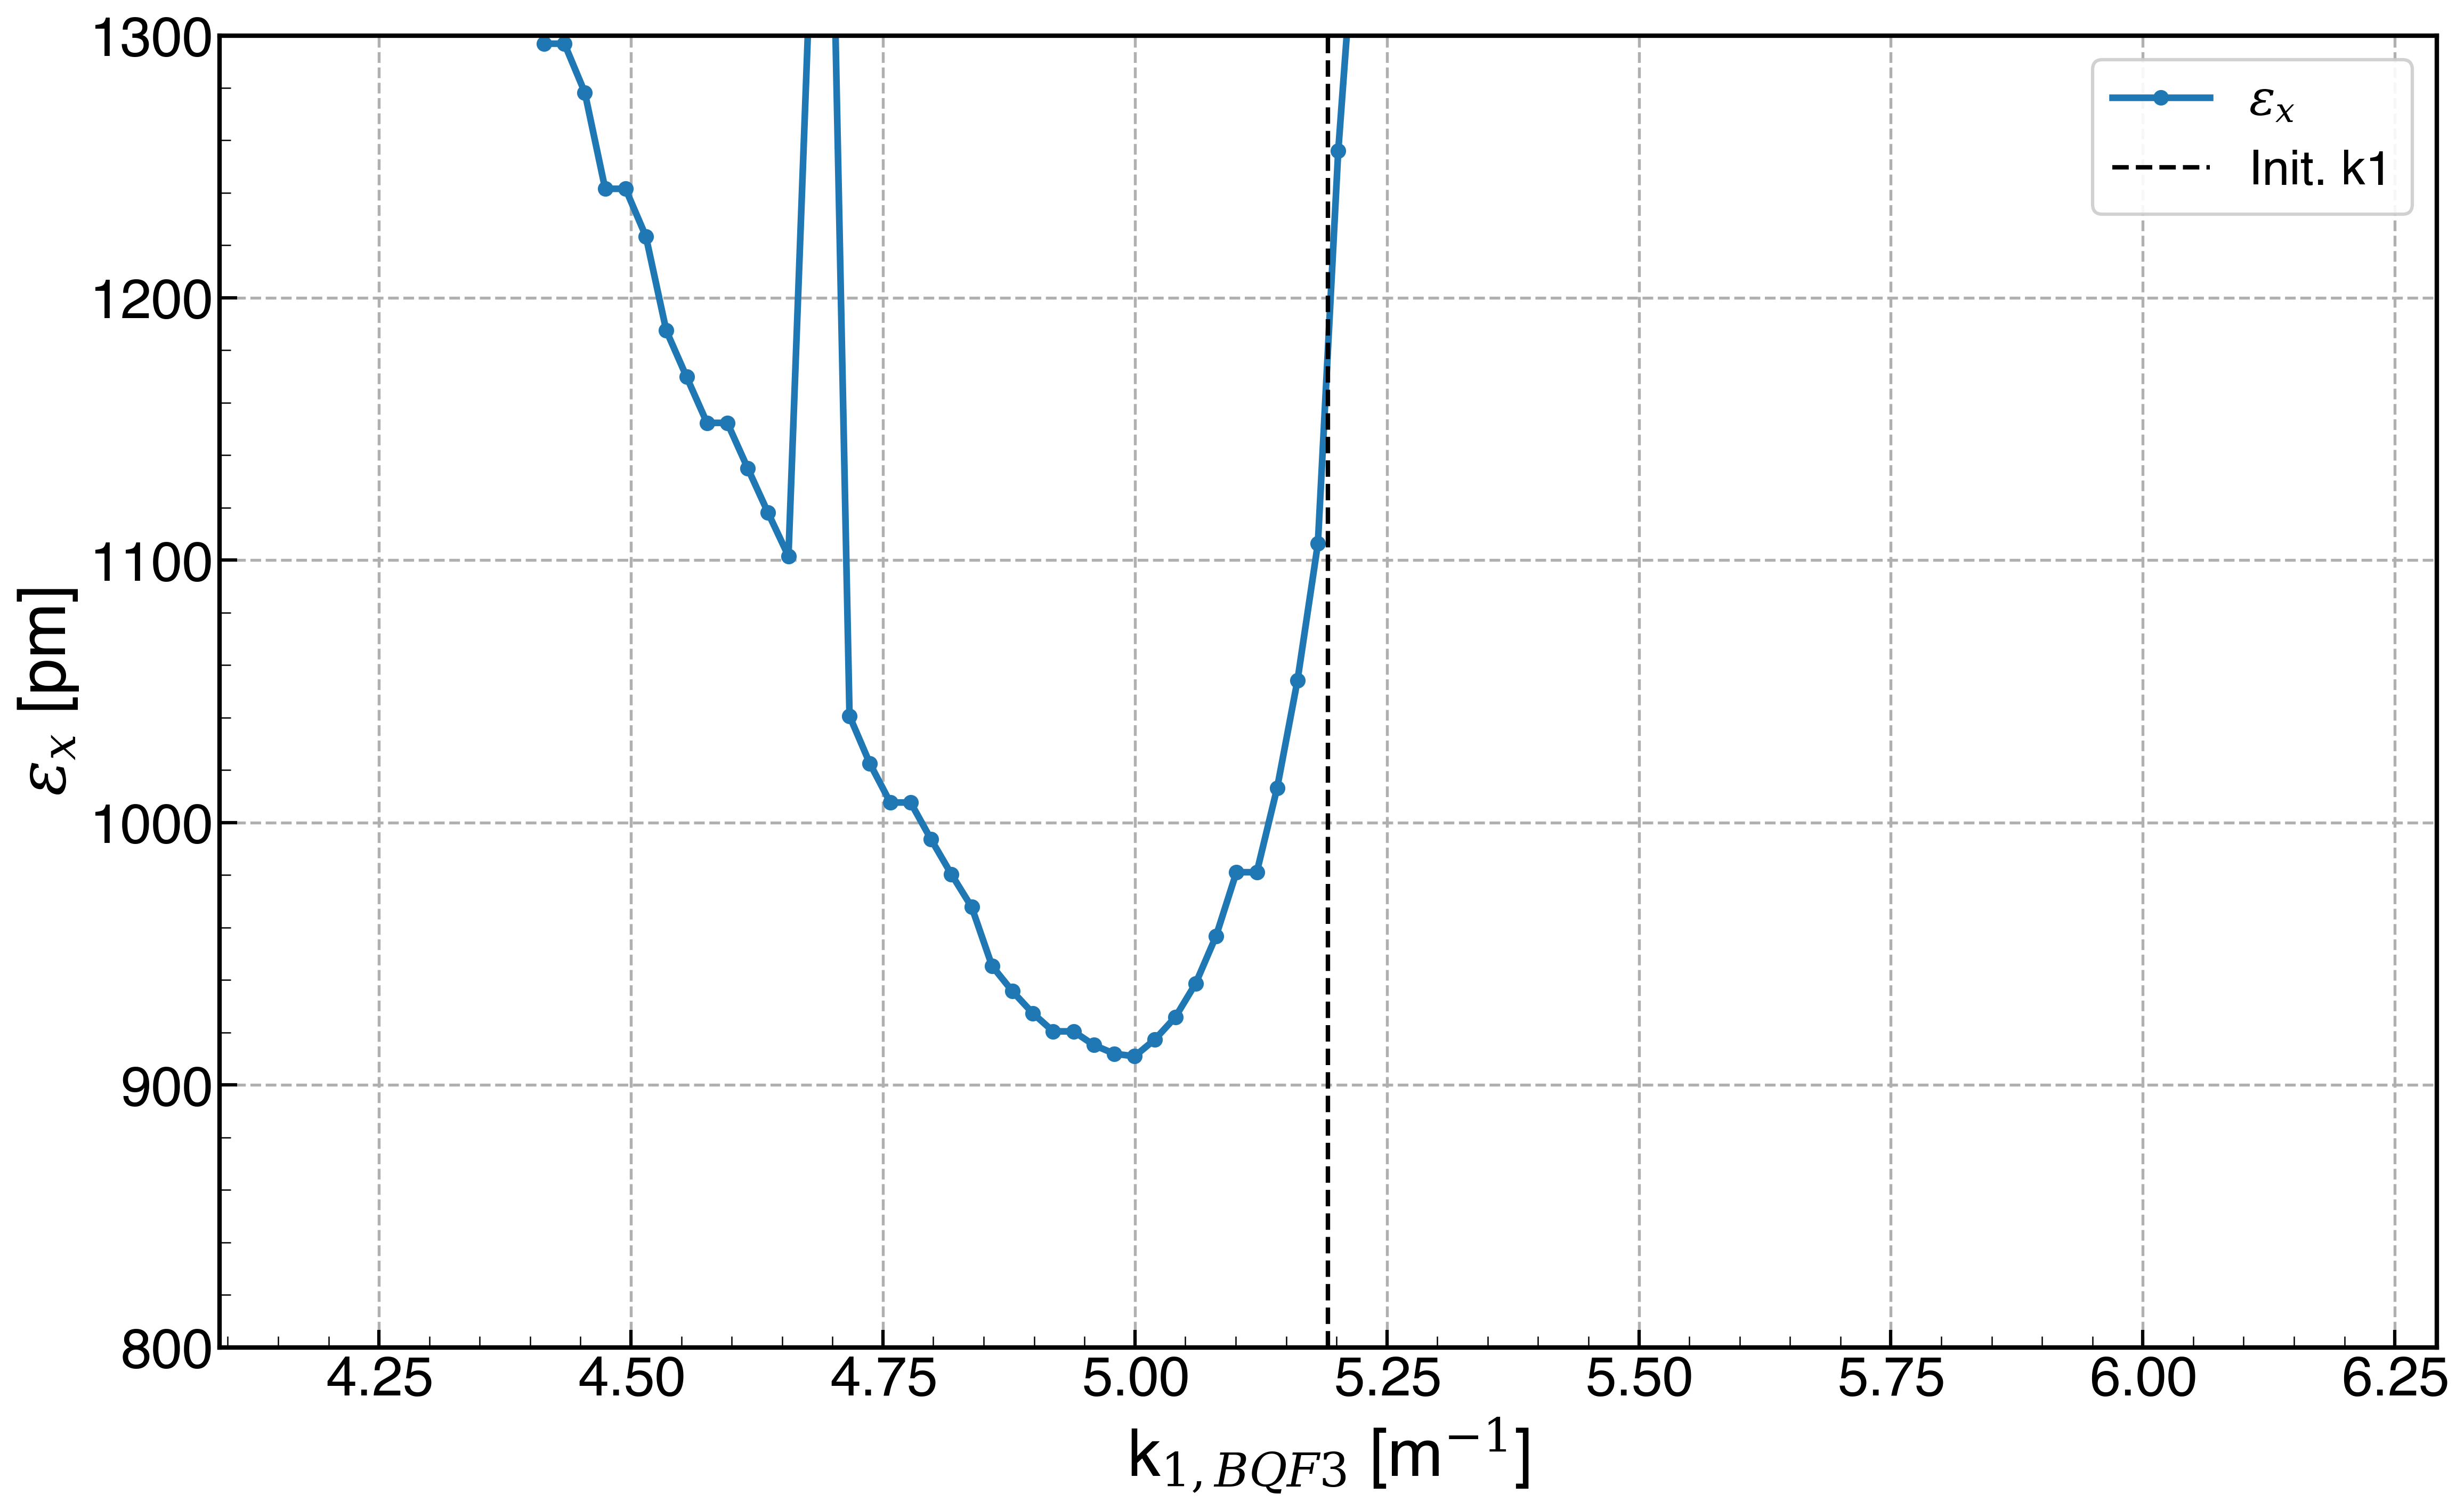

In [19]:
plt.plot(emit_res.index.to_numpy(), emit_res['ex']*1e12, '-o', lw=3, label='$\\epsilon_x$')
plt.axvline(x=init_k1_bqf3, ls='--', c='k', lw=2, label='Init. k1')
plt.legend(loc='best')
plt.ylim(800,1300)
plt.xlabel('k$_{1, BQF3}$ [m$^{-1}$]')
plt.ylabel('$\\epsilon_x$ [pm]');

In [24]:
# Let's set k1_bqf3 for the best emittance value

k1_bqf3_min_emit = emit_res['ex'].idxmin()

madx.globals.k1_bqf3 = k1_bqf3_min_emit
madx.command.twiss()
elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


(4.4663570802525135e-09, 0.0006081562312737487)

In [26]:
# And let's scan BQF4

init_k1_bqf4 = 5.191616161616161
delta_k1_bqf4 = 1
n_points = 100

k1_bqf4_scan = ScanConfig("k1_bqf4", initial_value=init_k1_bqf4, scan_start=init_k1_bqf4-delta_k1_bqf4, 
                         scan_end=init_k1_bqf4+delta_k1_bqf4, n_points=n_points)

In [27]:
%%time
emit_res = elettra_toolbox.scan_param_for_emittance(madx, k1_bqf4_scan, 'stdout.out')

Scanning parameter k1_bqf4 for emittance results.
Attempting emittance calculation for value of 4.19162
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.21182


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.23202
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.25222
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.27242
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.29263
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 4.31283
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.33303
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.35323
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.37343
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.39364
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.41384
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 4.43404
Running survey o

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Attempting emittance calculation for value of 5.34313
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.36333
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.38354
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.40374
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.42394
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.44414
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.46434
Running survey o

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.70677
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.72697
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.74717
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.76737
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.78758
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.80778
Running survey on the machine
Machine seems closed with respect to the

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.86838


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.88859


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.90879


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.92899
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.94919
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.96939
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 5.98960
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.00980
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.03000
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.05020
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.07040
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.09061
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.11081
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.13101
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.15121
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.17141
Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])
Attempting emittance calculation for value of 6.19162
Running survey on the machine


++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


Machine seems closed with respect to the provided tolerance (1.0 [mm])
CPU times: user 1.56 s, sys: 374 ms, total: 1.94 s
Wall time: 37.3 s


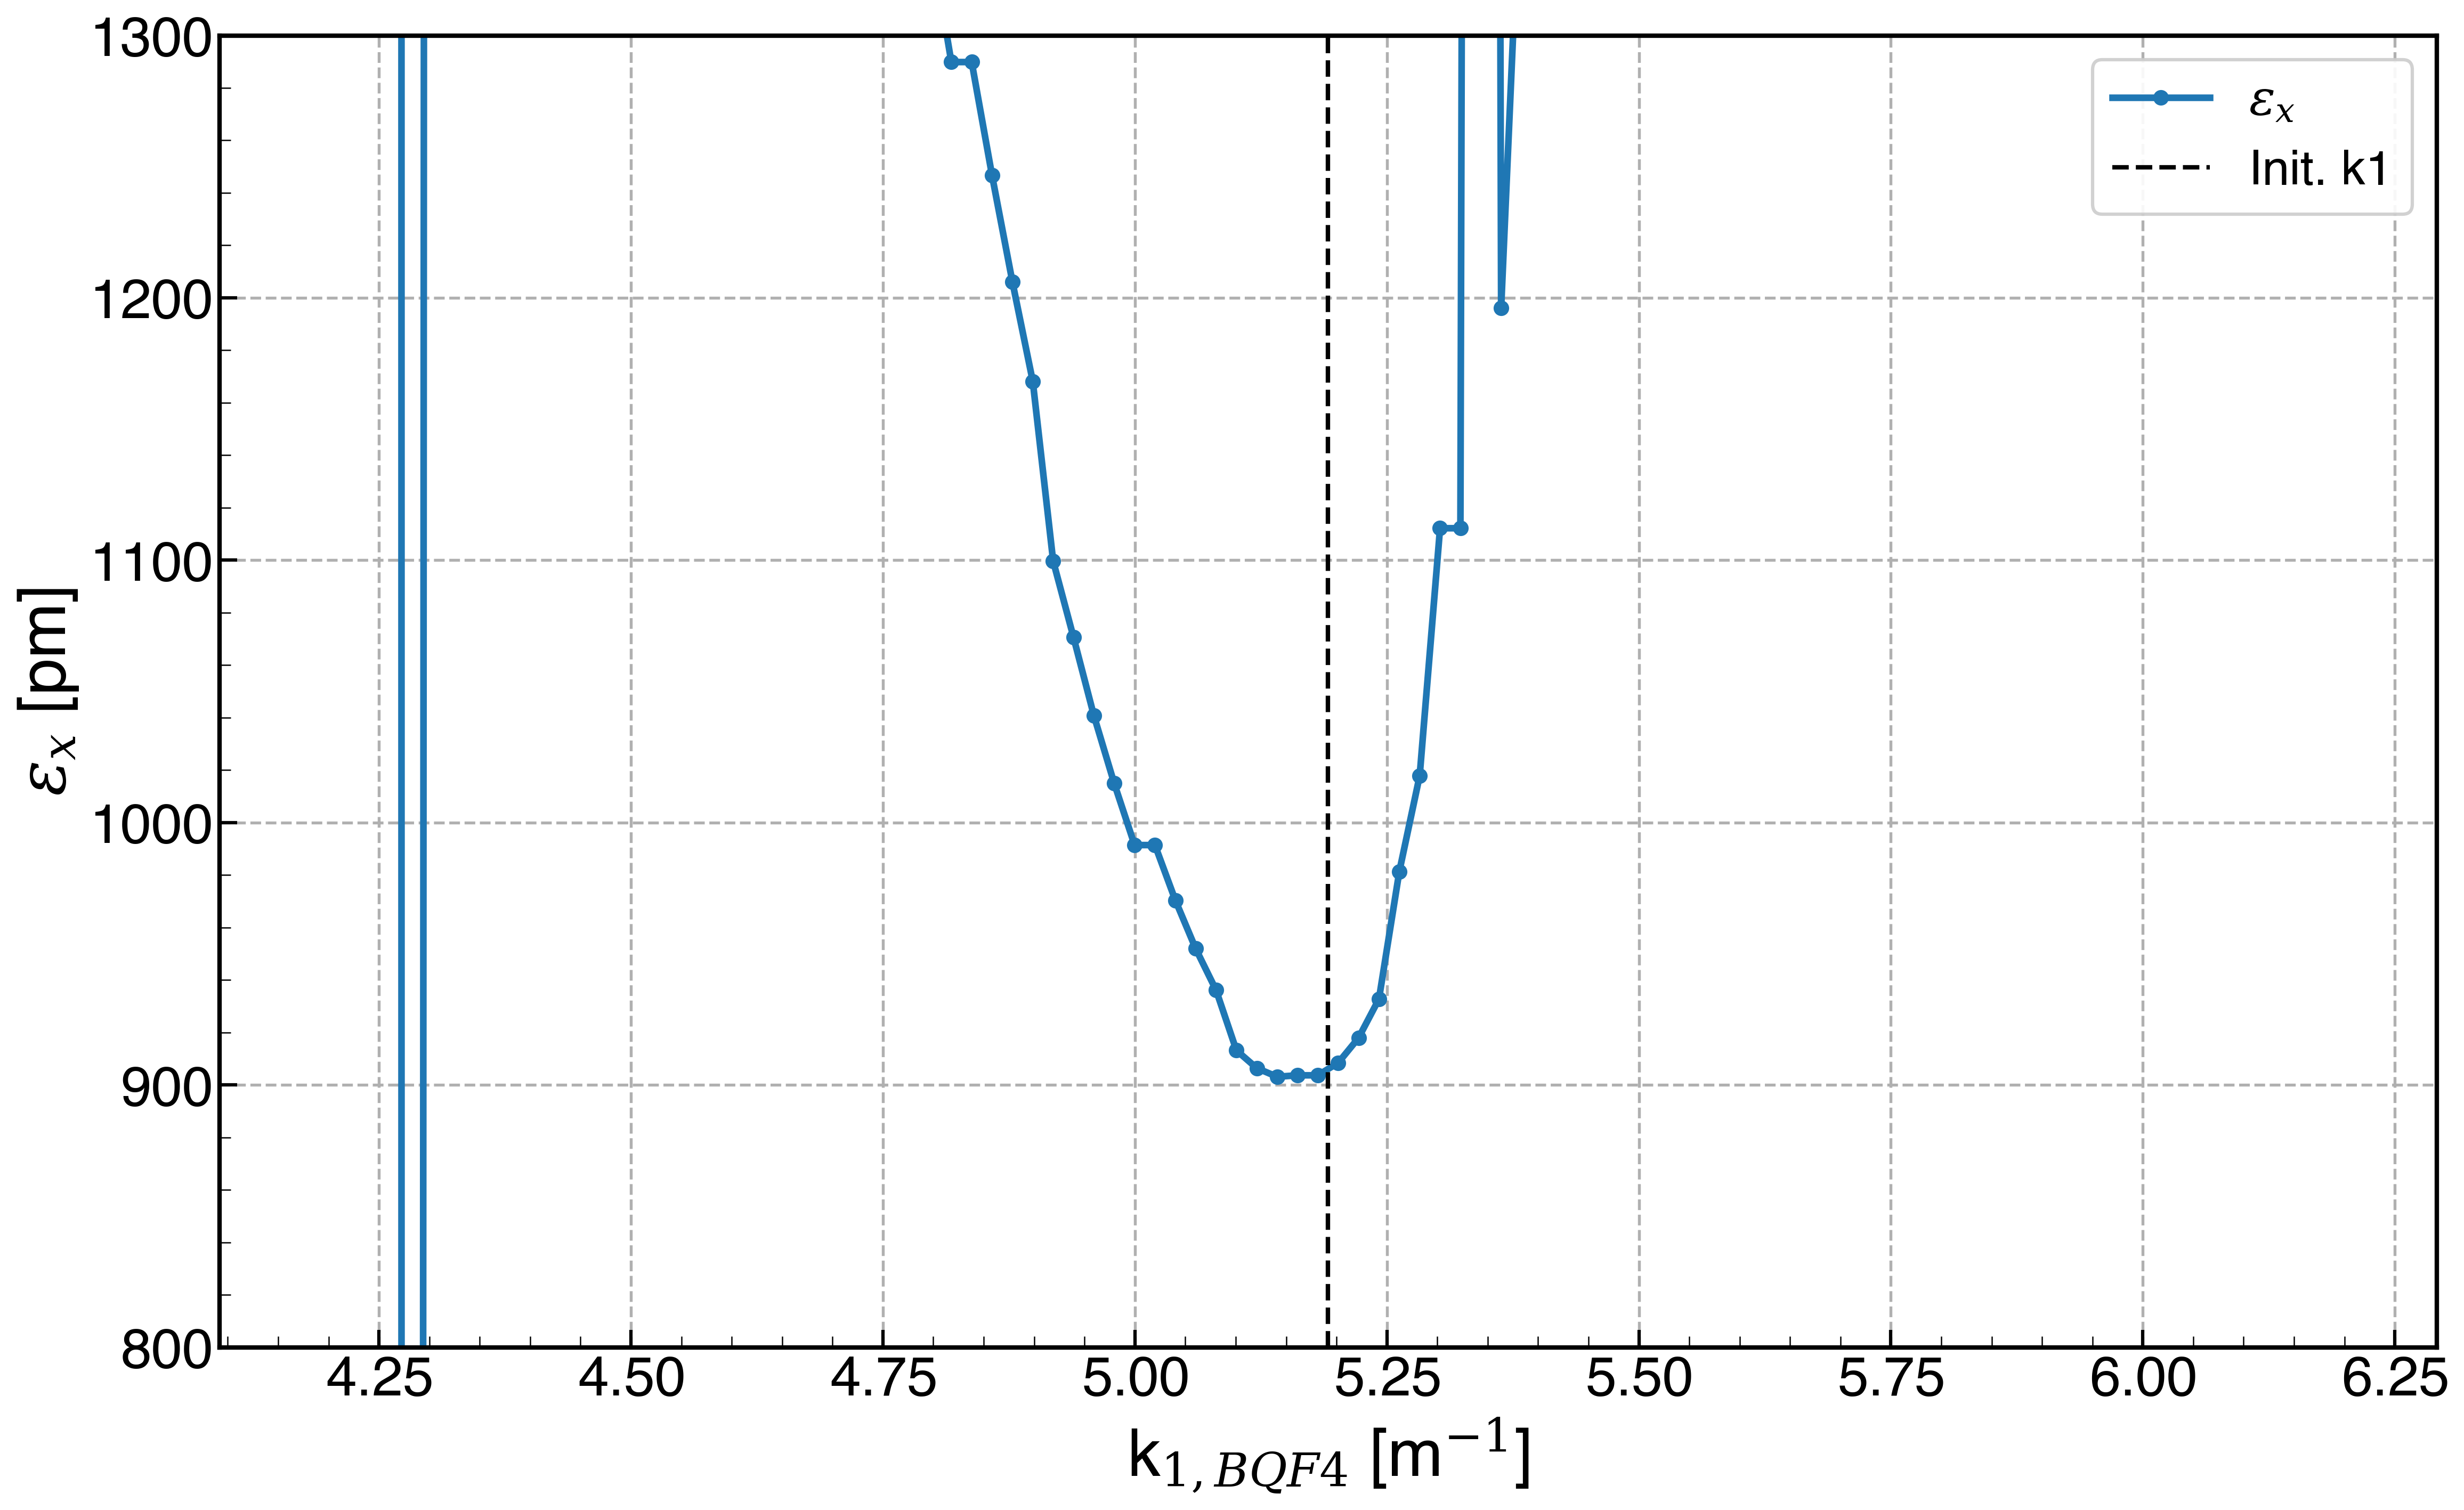

In [30]:
plt.plot(emit_res.index.to_numpy(), emit_res['ex']*1e12, '-o', lw=3, label='$\\epsilon_x$')
plt.axvline(x=init_k1_bqf4, ls='--', c='k', lw=2, label='Init. k1')
plt.legend(loc='best')
plt.ylim(800,1300)
plt.xlabel('k$_{1, BQF4}$ [m$^{-1}$]')
plt.ylabel('$\\epsilon_x$ [pm]');

No clear improvement seens... Let's set k1_bqf4 back to its value

In [37]:
# Let's set k1_bqf4 for the best emittance value

madx.globals.k1_bqf4 = init_k1_bqf4
madx.command.twiss()
elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


(4.4663570802525135e-09, 0.0006081562312737487)

In [39]:
# Compute Emittance

madx.command.emit(deltap=madx.globals.deltap)
madx.command.emit(deltap=madx.globals.deltap)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

Emittance x : 912.5574600000001 pm


2021-10-20 16:52:04.402 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-20 16:52:04.404 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-20 16:52:05.145 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-20 16:52:05.262 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-20 16:52:07.573 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-20 16:52:07.614 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-20 16:52:07.652 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


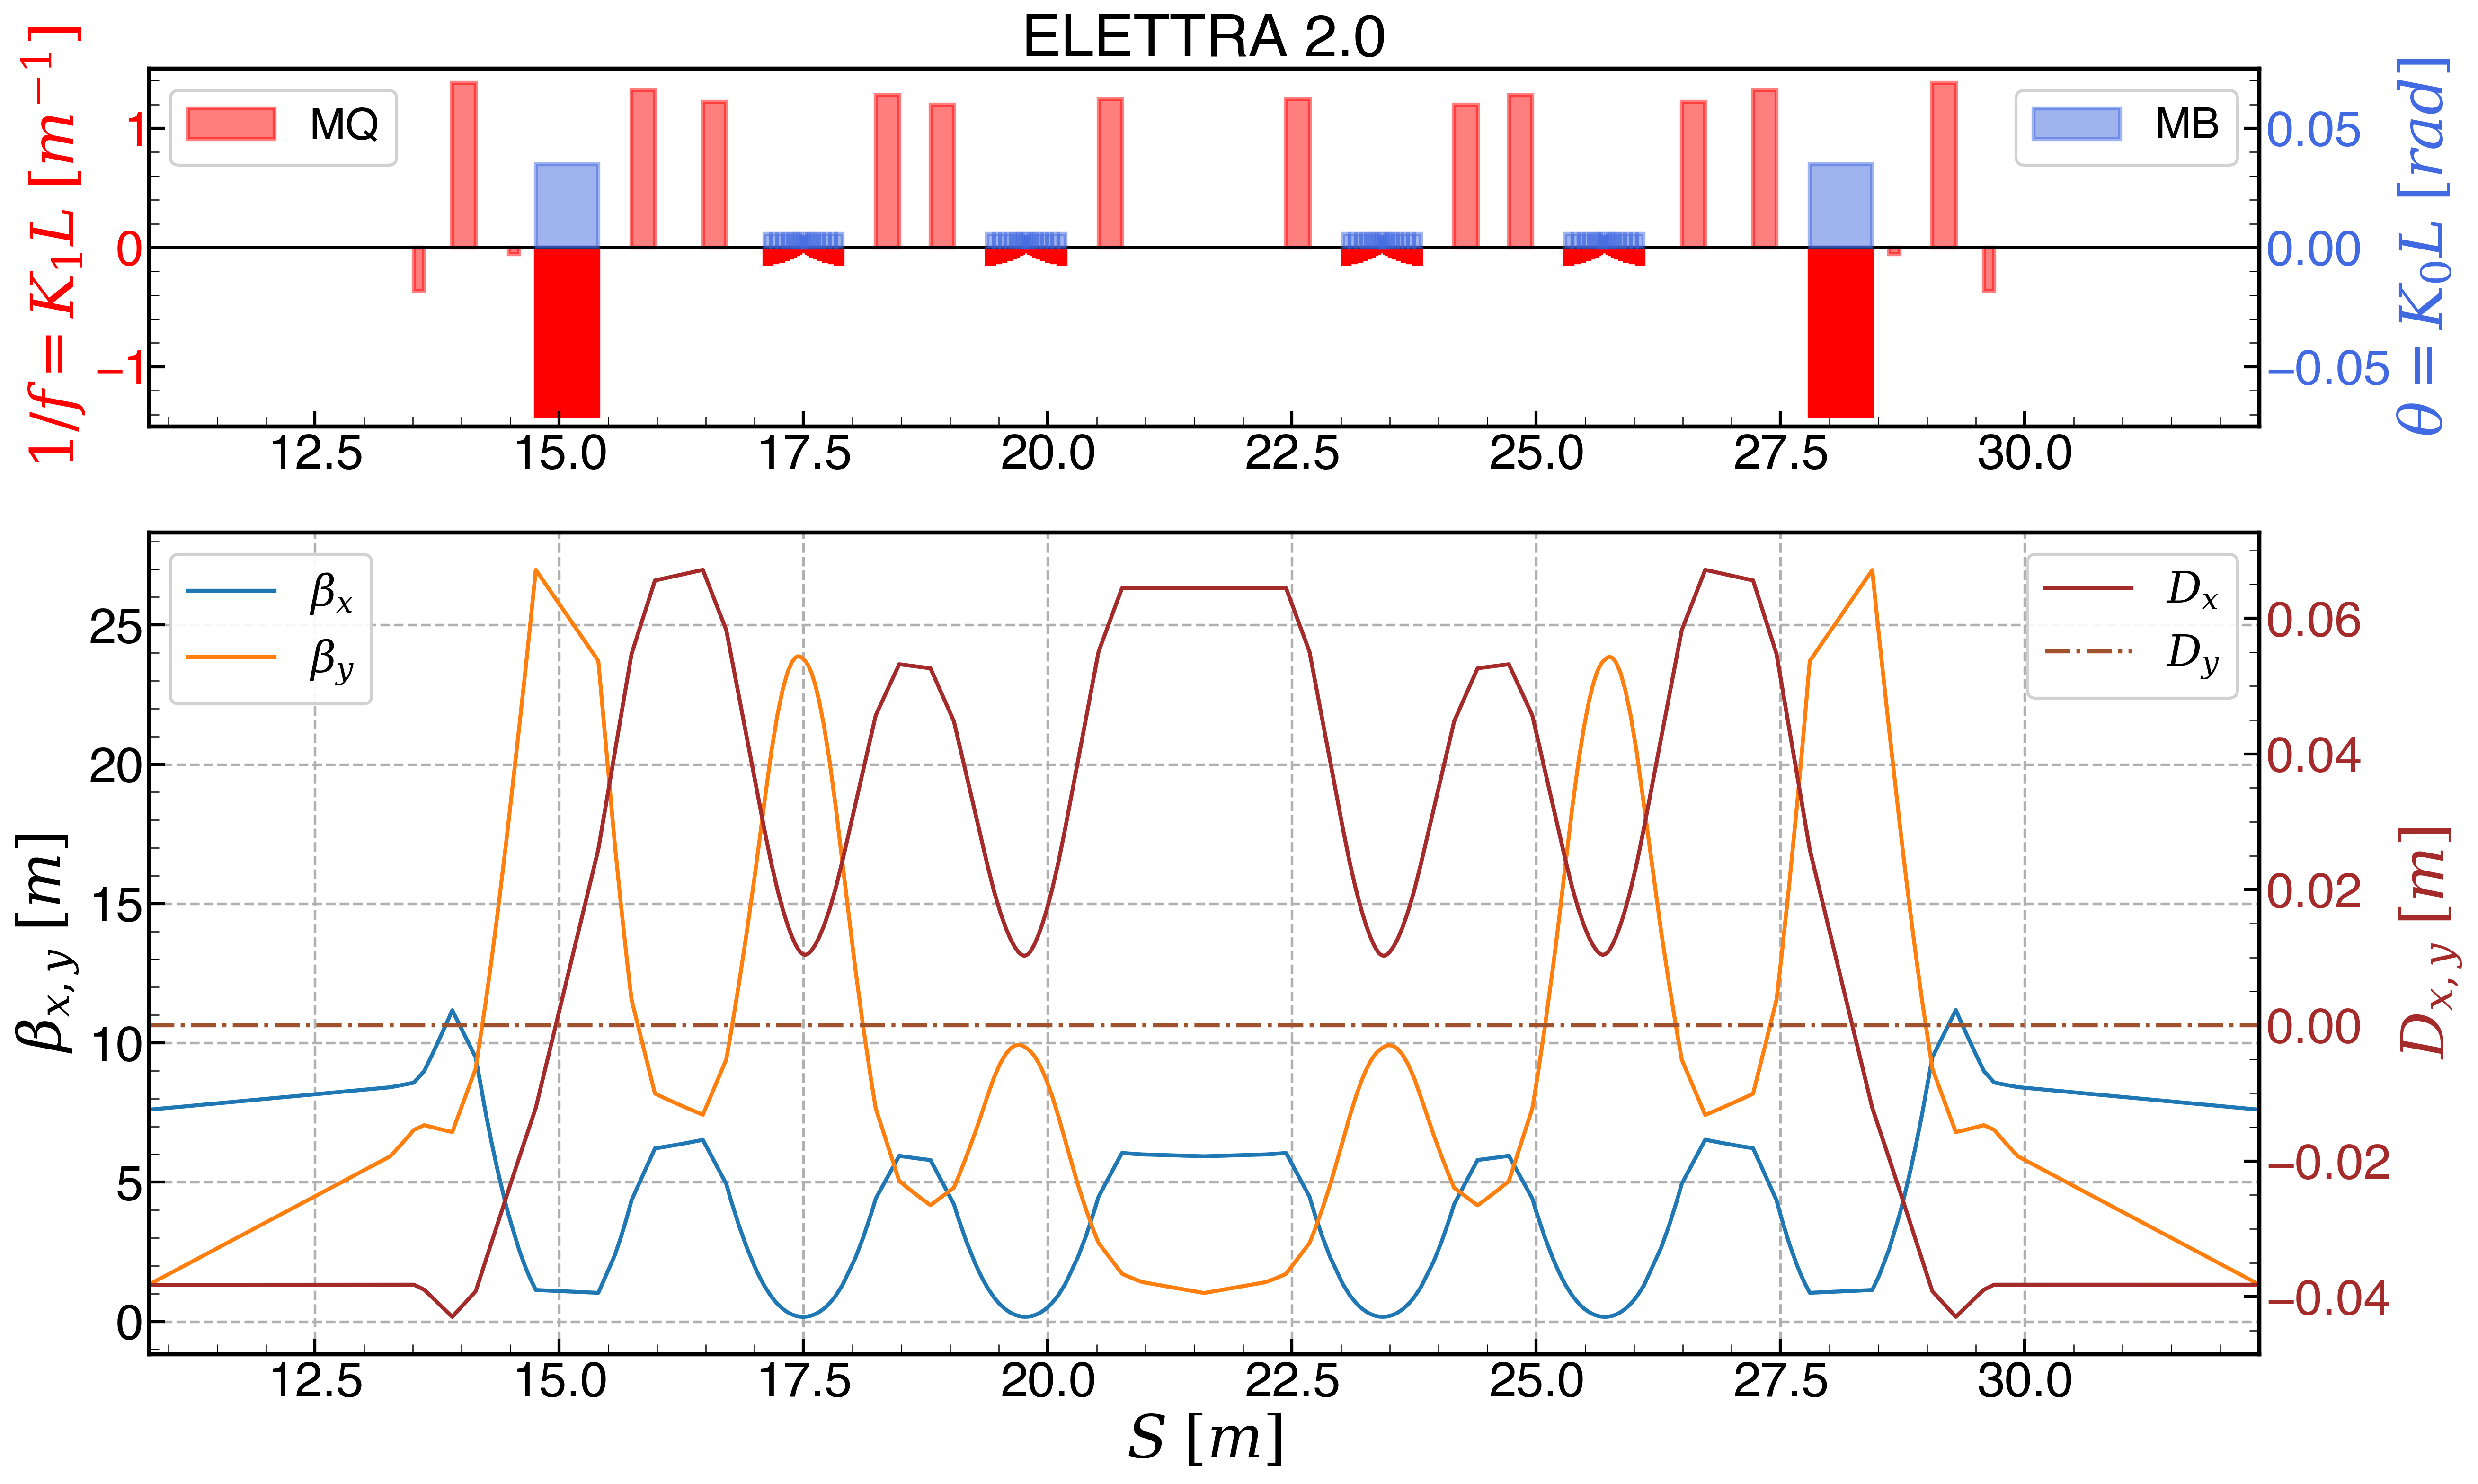

In [40]:
# Let's have a look...

s_start = twiss[twiss.name == "left_marker:1"]["s"][0]
s_end = twiss[twiss.name == "right_marker:1"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

Dispersion is back to crap in the LL... Shall we rematch with BQF1/2?

In [44]:
# Dispersion matching using the AB

madx.input(
    """
match, sequence=ring;
vary, name=k1_bqf1, step=1e-6;
vary, name=k1_bqf2, step=1e-6;
constraint, range=ll[1], dx=0, dy=0;
constraint, range=ll[3], dx=0, dy=0;
lmdif, calls=1000, tolerance=1e-21;
endmatch;


"""
)

print(madx.globals.tar)

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed
++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


1.535379320126229e-07


2021-10-20 16:55:53.096 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-20 16:55:53.097 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-20 16:55:54.027 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-20 16:55:54.433 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-20 16:55:56.383 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-20 16:55:56.416 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-20 16:55:56.456 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


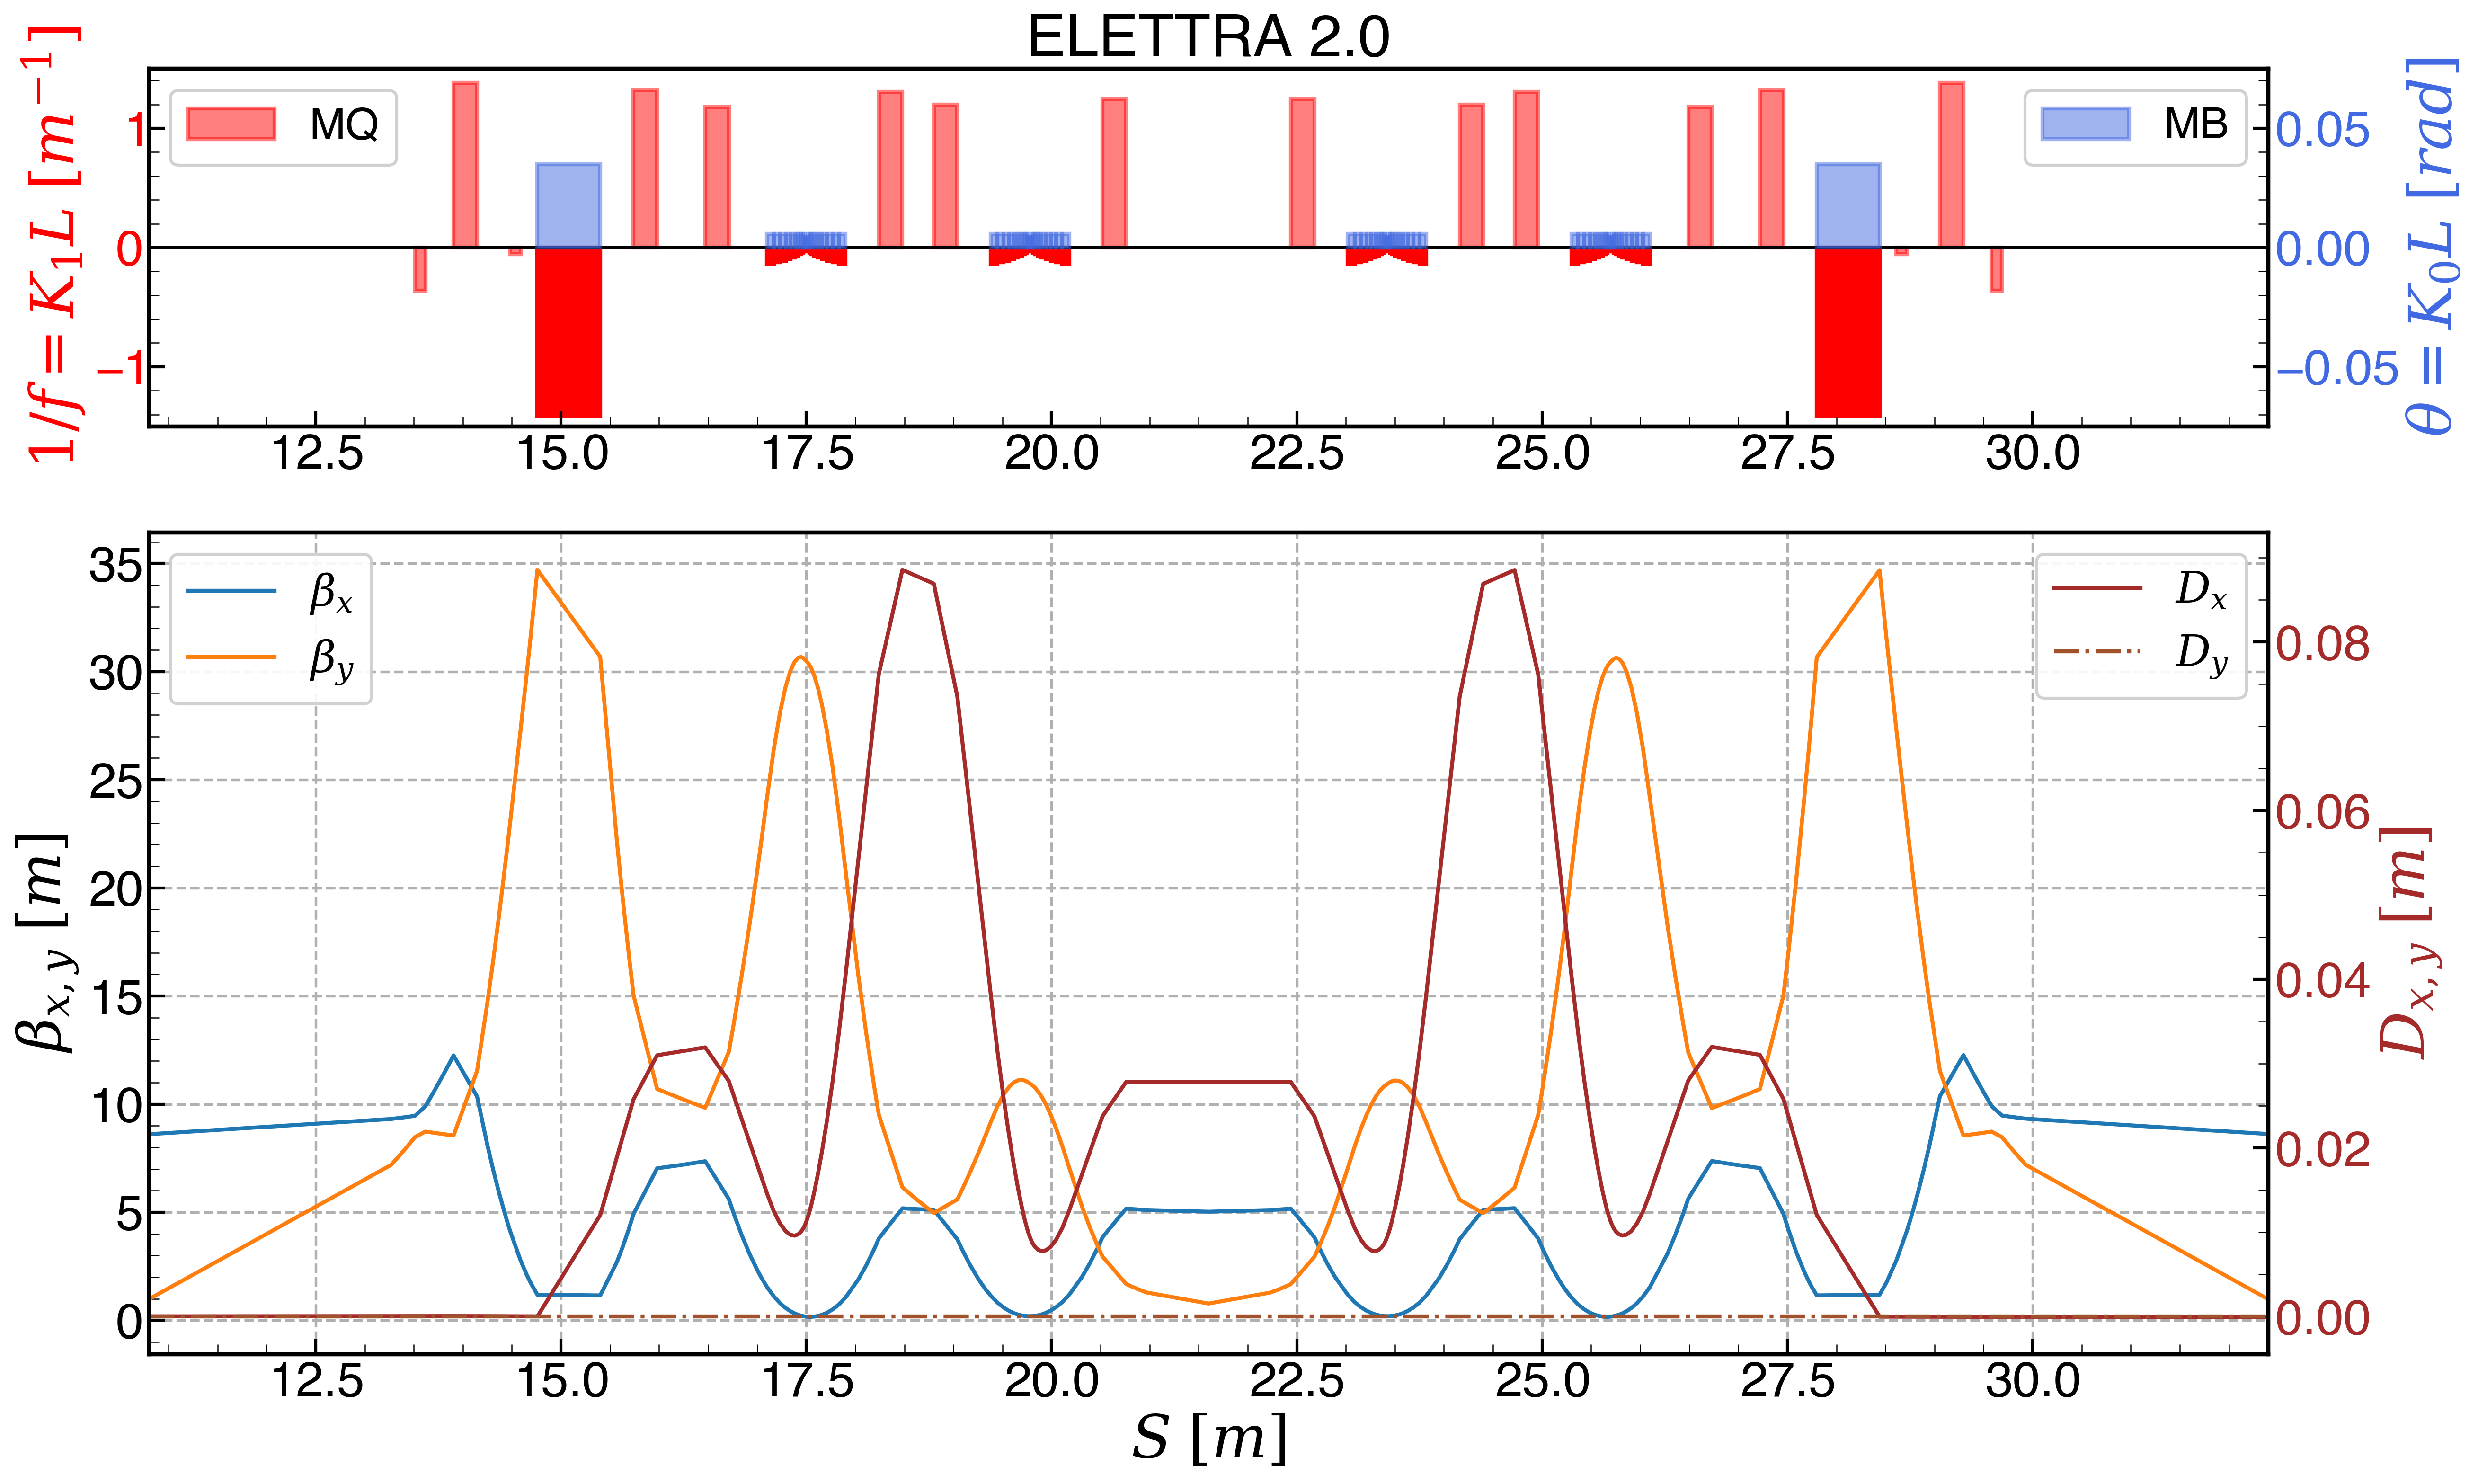

In [45]:
# Let's have a look...

s_start = twiss[twiss.name == "left_marker:1"]["s"][0]
s_end = twiss[twiss.name == "right_marker:1"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [47]:
# Compute Emittance

madx.command.emit(deltap=madx.globals.deltap)
madx.command.emit(deltap=madx.globals.deltap)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

Emittance x : 1244.1335 pm


---